In [1]:
import pandas as pd

df = pd.read_csv('datasets/penguins_size.csv')

In [2]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


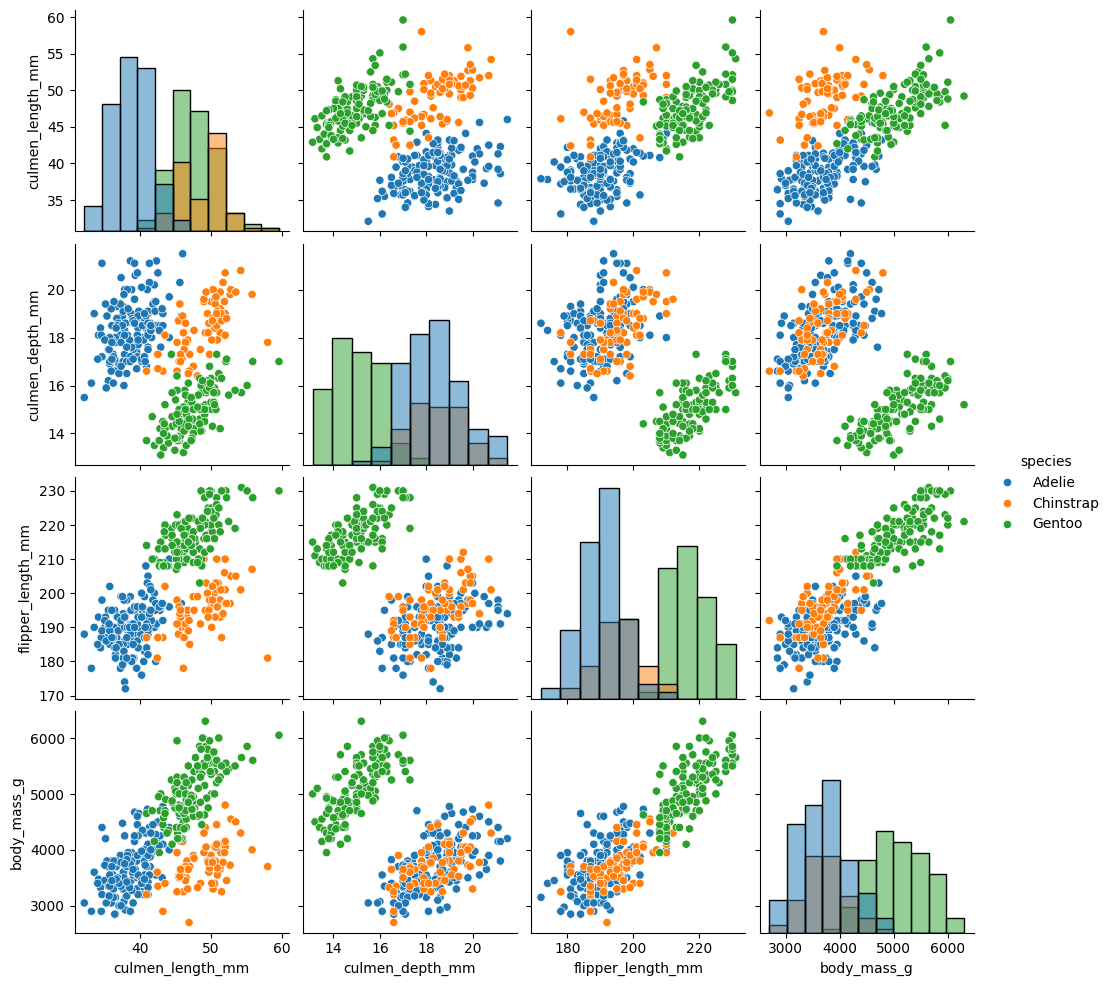

In [3]:
import seaborn as sns

sns.pairplot(df, hue='species', diag_kind='hist')

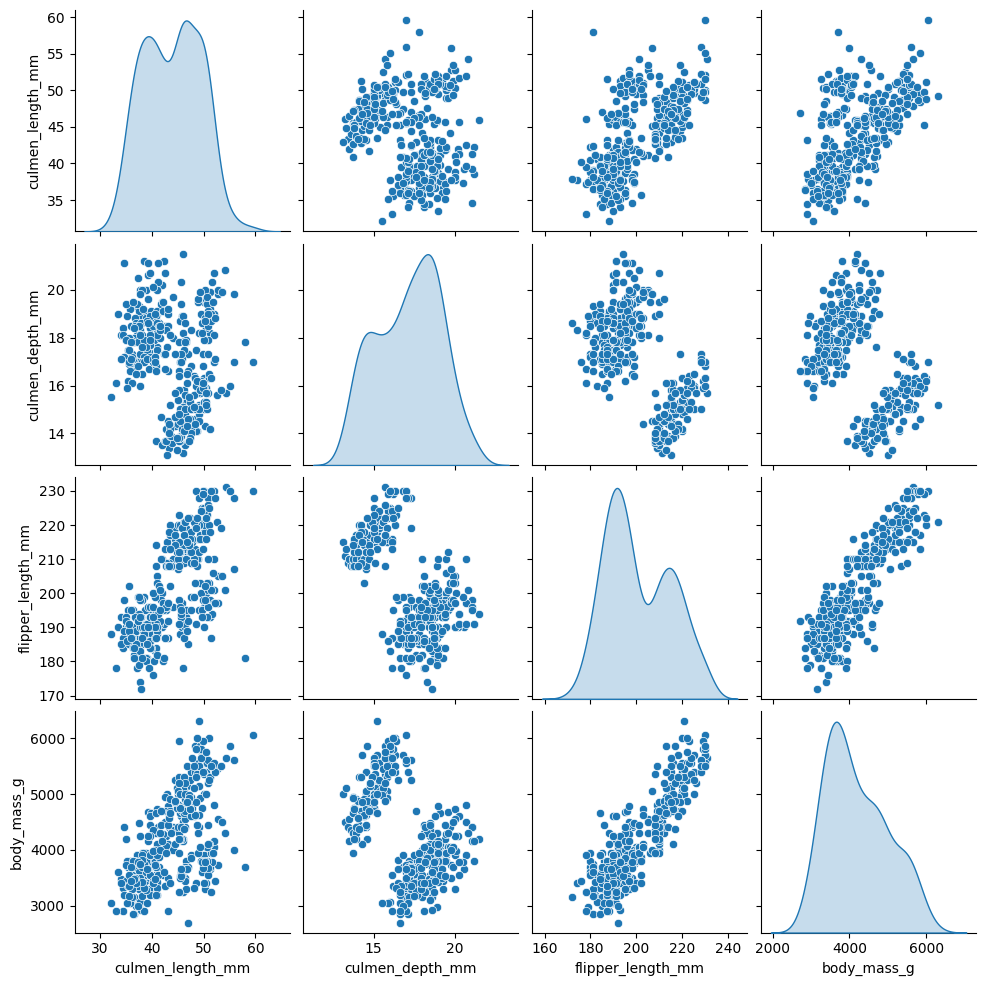

In [4]:
sns.pairplot(df, diag_kind="kde")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

import numpy as np

# Assuming X contains your features and y contains your labels
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[features]
y = np.ravel(df[['species']])

In [6]:
# imputing NaN data
imputer = KNNImputer(n_neighbors=5)
X_imputed = np.where(np.isnan(X), imputer.fit_transform(X), X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, stratify=y, random_state=42)

# Build pipeline with StandardScaler and SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Train the model using default settings
pipeline.fit(X_train, y_train)

# Predictions on training data
train_predictions = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_f1_macro = f1_score(y_train, train_predictions, average='macro')
train_conf_matrix = confusion_matrix(y_train, train_predictions)

# Predictions on testing data
test_predictions = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_f1_macro = f1_score(y_test, test_predictions, average='macro')
test_conf_matrix = confusion_matrix(y_test, test_predictions)

# Report metrics
print("Training Accuracy:", train_accuracy)
print("Training Macro-averaged F1-score:", train_f1_macro)
print("Training Confusion Matrix:\n", train_conf_matrix)

print("\nTesting Accuracy:", test_accuracy)
print("Testing Macro-averaged F1-score:", test_f1_macro)
print("Testing Confusion Matrix:\n", test_conf_matrix)


Training Accuracy: 0.9767441860465116
Training Macro-averaged F1-score: 0.9727424917080091
Training Confusion Matrix:
 [[113   1   0]
 [  4  47   0]
 [  1   0  92]]

Testing Accuracy: 0.9883720930232558
Testing Macro-averaged F1-score: 0.9860317460317459
Testing Confusion Matrix:
 [[37  1  0]
 [ 0 17  0]
 [ 0  0 31]]


(305, 148)


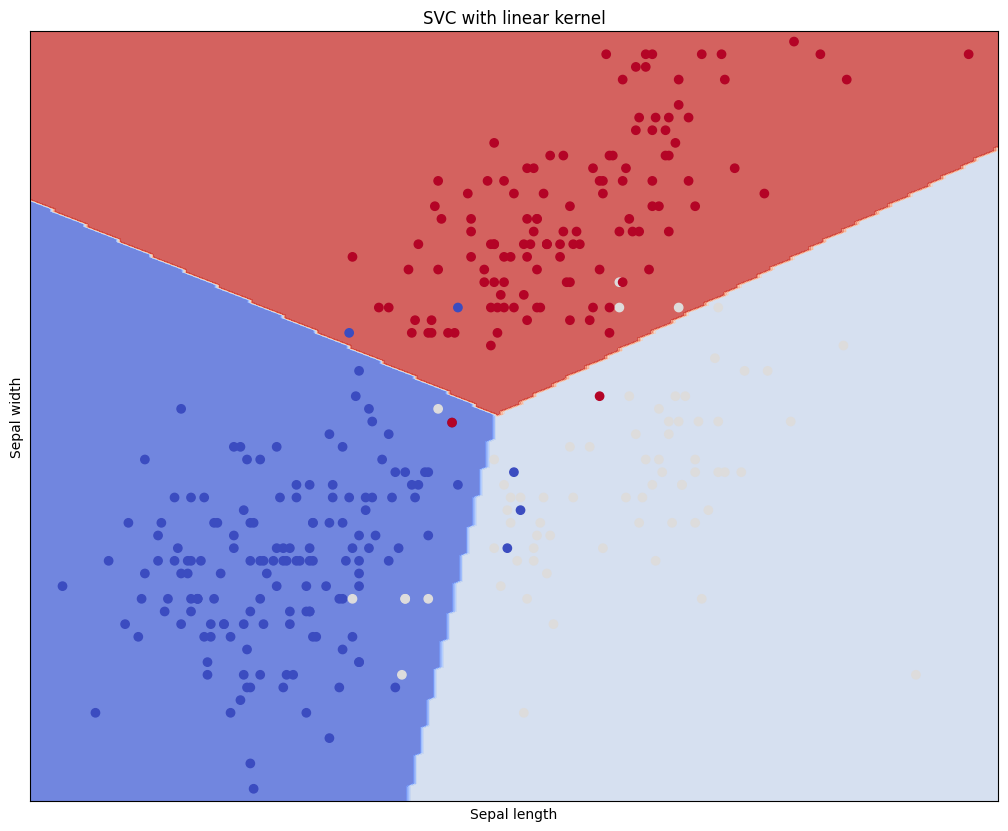

In [7]:
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder

plt.figure(figsize=(30, 24))
X_selected = X_imputed[:, [0, 2]]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

classifier = OneVsRestClassifier(SVC(kernel='linear'))
classifier.fit(X_selected, y_encoded)



df_selected = pd.DataFrame(X_selected, columns=[features[0], features[2]])
df_selected['species'] = y_encoded

h = 0.2
x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
print(Z.shape)
plt.contourf(np.array(xx, dtype=float), np.array(yy, dtype=float), Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y_encoded, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('SVC with linear kernel')

plt.show()

# Grid Search

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 0.01, 0.001],
    'degree': [2, 3],
}


svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(X_selected, y_encoded)

best_params =  grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
0.9650468883205455
